In [28]:
%load_ext autoreload
%autoreload 2
import glob

import matplotlib.pyplot as plt
import MDAnalysis as mda
import nglview as nv
import numpy as np
import pynucl
import scipy as sp
from scipy import stats
from Nucl_analysis import *
from scipy.stats import binom
from tqdm.auto import tqdm, trange

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Task: Evaluating FRET Efficiency Values for Nucleosome with Linkers
In this task, we use the experimental FRET efficiency values for a system consisting of a nucleosome with a linker sequence. Where the fluorophore Su3 is introduced into the DNA sequence, in the linker region of the nucleosome at positions 10-15-20-25-25-30-35 nucleotide park (n.p.). Spacers from two different companies, Syntol© and Lumiprobe©, were used to collect experimental data for the Cy3 fluorophore. 

 - [Syntol©](https://github.com/NVKristovs/nucl_FRET_analysis/blob/main/images/Syntol_Lumiprobe_Cy3.jpg) linkers at positions 15, 20 had a spacer length of 16 Å. 
 - [Lumiprobe©](https://github.com/NVKristovs/nucl_FRET_analysis/blob/main/images/Syntol_Lumiprobe_Cy3.jpg) linkers at positions 10, 25, 30, 35 had a spacer length of 24 Å. 
 
The fluorophore [Су5](https://github.com/NVKristovs/nucl_FRET_analysis) was introduced into the histone H1 sequence at positions 101 and 195 amino acids, with a spacer length of 11 Å.

Reaction with [Maleimide](https://ru.lumiprobe.com/protocols/protein-maleimide-labeling)) was used to label the protein.

The library [LabelLib](https://github.com/Fluorescence-Tools/LabelLib) was used to determine the available amount of Cy3 and the limitations of the localization region of Cy5 introduced into the protein sequence of 101 and 195 n.b. hrs. This library creates a three-dimensional matrix describing the label localization region based on the specified parameters.

Using the LabelLib library, we determined the regions of available volume of Cy3 and possible localization of Cy5. By analyzing the coordinates of the available volume voxels obtained from LabelLib for Cy3, we determined which voxels in the Cy5 localization region allow FRET efficiency values that fall within the range of one standard deviation of FRET efficiency from experimental data. Thus, we limited the volume in which the Cy5 fluorophore amino acid could be located. We retained only those voxel coordinates that describe the experimental FRET efficiency values. We also calculated the relative probability of finding the Cy5 fluorophore in a particular voxel. This probability is calculated as the sum of the number of voxel hits within the range of one standard deviation of FRET efficiency for a fluorophore introduced at one of the positions (10/15/20/25/30/35) divided by the maximum number of hits for that Cy3 position and summed for all 6 Cy3 introduction positions.

- Dimura, M., Peulen, T.O., Hanke, C.A., Prakash, A., Gohlke, H. and Seidel, C.A., 2016. [Quantitative FRET studies and integrative modeling unravel the structure and dynamics of biomolecular systems. Current opinion in structural biology](https://www.sciencedirect.com/science/article/pii/S0959440X1630197X?via%3Dihub), 40, pp.163-185.
--------------------------------------------------------------------------------
### Задача: Оценить значения эффективности FRET для системы: нуклеосома с линкерами. 
В данной задаче мы используем эксперементальные значения эффективность FRET для системы, состоящей из нуклеосомы с линкерной последовательностью. Где флуорофор Су3 введен в последовательность ДНК, в линкерной области нуклеосомы в позиции 10-15-20-25-30-35 нуклеотидных парк (н.п.). При сборе эксперементальных данных для флуорофора Cy3 использовались спейсеры от двух различных компаний: Syntol© и Lumiprobe©. 
Где линкеры от компании [Syntol©](https://github.com/NVKristovs/nucl_FRET_analysis/blob/main/images/Syntol_Lumiprobe_Cy3.jpg) в позициях 15, 20. — длина спейсера 16 Å.
Линкеры от компании [Lumiprobe©](https://github.com/NVKristovs/nucl_FRET_analysis/blob/main/images/Syntol_Lumiprobe_Cy3.jpg) в позициях 10, 25, 30, 35. — длина спейсера 24 Å.

Флуорофор [Су5](https://github.com/NVKristovs/nucl_FRET_analysis) введен в последовательность гистона Н1 в позиции 101 и 195 аминокислот (а.к.), длина спейсера 11 Å.

Для маркировки белка использовалась реакция с [Малеимидом](https://ru.lumiprobe.com/protocols/protein-maleimide-labeling)

Для определения доступного объема Cy3 и ограничений области локализации Сy5 введенного в белковую последовательность чреез 101 и 195 н.к. была использована библиотека [LabelLib](https://github.com/Fluorescence-Tools/LabelLib). Эта библиотека создает трехмерную матрицу, описывающую область локализации метки на основе заданных параметров.

С использованием библиотеки LabelLib мы определили области доступного объема Cy3 и возможной локализации Cy5. Путем анализа координат вокселей доступного объема, полученных из LabelLib для Cy3, мы определили, какие воксели в области локализации Cy5 позволяют получить значения эффективности FRET, входящие в диапазон одного стандартного отклонения эффективности ФРПЭ из экспериментальных данных. Таким образом, мы ограничили объем, в котором может находиться аминокислота с флуорофором Cy5. Мы сохранили только те координаты вокселей, которые описывают экспериментальные значения эффективности FRET. Также была рассчитана относительная вероятность нахождения флуорофора Cy5 в конкретном вокселе. Эта вероятность вычисляется как сумма количества попаданий вокселя в диапазон одного стандартного отклонения эффективности ФРПЭ для флуорофора, введенного в одну из позиций (10/15/20/25/30/35), деленная на максимальное количество попаданий для данной позиции  Cy3 и суммированная для всех 6 позиций введения Cy3.


### Calculating the available volume matrices for Cy3 and Cy5 

In [5]:
resid_list=[10, 15, 20, 25, 30, 35] #Cy3 positions in the linker region of DNA
rad_list = [24, 16, 16, 24, 24, 24] #Spacer radii 
cloud_dict_cy3 = {}
dna_nu = mda.Universe("PDB/nucl_DNA_H1_linkered.pdb")
for pos, rad in zip(resid_list, rad_list):
    av1 = labellib_length_calculating_av1(dna_nu, chain_Dy='J', attach_n_Dy=pos, linker_length_Dy=rad, 
                                                                   linker_width = 0.5, dye_radius=7, simulation_grid_spacing=3,
                                                                   # pqr1_name=f'pqr_file/Cy3_pos_{pos}_test'
                                                                   # You can save the available volume areas as pqr files
                                                                  )
    cloud_dict_cy3[pos]=av1

In [8]:
aa_list = [101,195] # amino acid
amino_list = [109, 109] # 109 in H1.4 is equivalent to 97 in H1.0
amino_rad = [11+14, 11+343] # Spacer length + amino acid site length
grid_list = [3,6] # Step of the three-dimensional matrix in angstroms 
cloud_dict_cy5 = {}
for pos, rad, aa, grid in zip(amino_list, amino_rad, aa_list, grid_list):
    av1 = labellib_length_calculating_av1(dna_nu, chain_Dy='u', attach_n_Dy=pos, linker_length_Dy=rad, 
                                                                   linker_width = 0.2, dye_radius=1, simulation_grid_spacing=grid,
                                                                   # pqr1_name=f'pqr_file/Cy5_pos_{pos}_test'
                                                                  )
    cloud_dict_cy5[aa]=av1

#### Visualize AV

In [9]:
dna_nu = mda.Universe("PDB/nucl_DNA_H1_linkered.pdb")
view = nv.show_mdanalysis(dna_nu)
view.add_licorice(selection='protein')
view 

NGLWidget()

In [10]:
# view.download_image(filename ='av_cy3.png', transparent=1, factor=8)

In [10]:
palette= ['#5252AB', '#FB5607', '#339425', '#8338EC', '#F9C80E', '#3A86FF', '#F64A8A', '#006C67' ]

In [12]:
for index, cloud in enumerate(glob.glob('pqr_file/Cy3_pos_*.pqr')):
    view.add_component(nv.FileStructure(cloud))
    view[-1].clear()
    view[-1].add_surface(color=palette[index],opacity=0.7)

In [7]:
view.add_component(
    nv.FileStructure("pqr_file/Cy5_pos_109_25_1.pqr")
)  # The theoretical area where Cy5 introduced in 101 amino acids could be
view[-1].clear()
view[-1].add_surface(color=palette[6], opacity=0.8)

In [98]:
view.add_component(
    nv.FileStructure("pqr_file/Cy5_pos_109_354_1.pqr")
)  # The theoretical area where Cy5 introduced in 195 amino acids could be
view[-1].clear()
view[-1].add_surface(color=palette[7], opacity=0.8)

### Working with experimental data

In [13]:
E_101 = np.array([0.72, 0.76, 0.56, 0.56, 0.46, 0.39]) # FRET experimental data
E_195 = np.array([0.43, 0.48, 0.66, 0.47, 0.52, 0.44]) # FRET experimental data
FWHM_array_101 = np.array([0.3865, 0.2556, 0.3857, 0.3047, 0.3981, 0.3728]) # full width at the half maximum
FWHM_array_195 = np.array([0.3584, 0.3120, 0.3299, 0.3425, 0.3121, 0.3178]) # full width at the half maximum
sigma_array_101 = FWHM_array_101/2.354 # convert FWHM to sigma https://brainder.org/2011/08/20/gaussian-kernels-convert-fwhm-to-sigma/
sigma_array_195 = FWHM_array_195/2.354 # convert FWHM to sigma
sigma_array_101, sigma_array_195

(array([0.16418862, 0.10858114, 0.16384877, 0.12943925, 0.1691164 ,
        0.15836873]),
 array([0.15225149, 0.13254036, 0.14014444, 0.14549703, 0.13258284,
        0.13500425]))

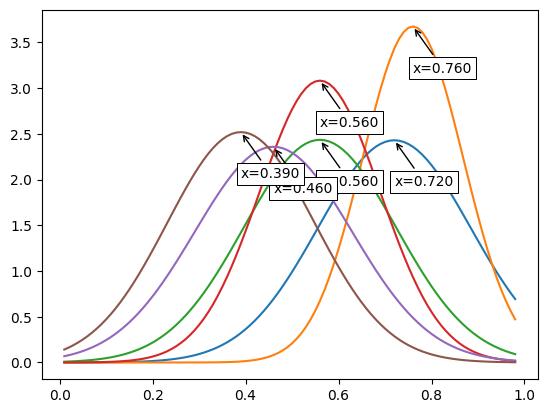

In [14]:
for mu, sigma in zip(E_101, sigma_array_101):
    gaus( mu, sigma)

In [15]:
sigma = 1 # Choose the number of sigmas (1, 2 or 3)

E_p3_101 = E_101 + sigma_array_101*sigma # max + sigma
E_m3_101 = E_101 - sigma_array_101*sigma # max - sigma 

E_p3_195 = E_195 + sigma_array_195*sigma
E_m3_195 = E_195 - sigma_array_195*sigma

E_p3_101 = np.clip(E_p3_101,0.01,0.99) # limit the range of FRET efficiency values
E_m3_101 = np.clip(E_m3_101,0.01,0.99)
E_p3_195 = np.clip(E_p3_195,0.01,0.99)
E_m3_195 = np.clip(E_m3_195,0.01,0.99)
E_p3_101, E_m3_101, E_p3_195, E_m3_195

(array([0.88418862, 0.86858114, 0.72384877, 0.68943925, 0.6291164 ,
        0.54836873]),
 array([0.55581138, 0.65141886, 0.39615123, 0.43056075, 0.2908836 ,
        0.23163127]),
 array([0.58225149, 0.61254036, 0.80014444, 0.61549703, 0.65258284,
        0.57500425]),
 array([0.27774851, 0.34745964, 0.51985556, 0.32450297, 0.38741716,
        0.30499575]))

In [16]:
R0=53.0 # Förster radius value for the Cy3-Cy5 pair
Rda_p3_101 = R0*((1-E_p3_101)/E_p3_101)**(1/6) #Convert FRET efficiency to Rda values (distance between the donor and the acceptor)
Rda_m3_101 = R0*((1-E_m3_101)/E_m3_101)**(1/6)
Rda_p3_195 = R0*((1-E_p3_195)/E_p3_195)**(1/6)
Rda_m3_195 = R0*((1-E_m3_195)/E_m3_195)**(1/6)
Rda_p3_101,Rda_m3_101,Rda_p3_195,Rda_m3_195

(array([37.76970496, 38.68866588, 45.13627628, 46.40352393, 48.53186426,
        51.31304125]),
 array([51.05628374, 47.75473749, 56.85740904, 55.52791466, 61.48590706,
        64.72488491]),
 array([50.14680338, 49.10486229, 42.05979766, 49.00286741, 47.71392457,
        50.39585204]),
 array([62.1510762 , 58.86986466, 52.30269532, 59.88848539, 57.20581771,
        60.79830631]))

In [17]:
Rda_in_101 = Rda_p3_101.round(2)
Rda_out_101 = Rda_m3_101.round(2)
Rda_in_195 = Rda_p3_195.round(2)
Rda_out_195 = Rda_m3_195.round(2)
Rda_in_101,Rda_out_101,Rda_in_195,Rda_out_195

(array([37.77, 38.69, 45.14, 46.4 , 48.53, 51.31]),
 array([51.06, 47.75, 56.86, 55.53, 61.49, 64.72]),
 array([50.15, 49.1 , 42.06, 49.  , 47.71, 50.4 ]),
 array([62.15, 58.87, 52.3 , 59.89, 57.21, 60.8 ]))

### Calculation of the distance matrix between Cy3 and Cy5 

In [18]:
resid_list=[10, 15, 20, 25, 30, 35]
dict_matrix_101 = {}
dict_matrix_195 = {}
for pos in cloud_dict_cy3.keys():
    loc_101 = cloud_dict_cy5[101].points()[:3].T
    loc_195 = cloud_dict_cy5[195].points()[:3].T
    loc_cy3 = cloud_dict_cy3[pos].points()[:3].T
    dict_matrix_101[pos] = sp.spatial.distance.cdist(loc_101,loc_cy3)
    dict_matrix_195[pos] = sp.spatial.distance.cdist(loc_195,loc_cy3)

In [19]:
resid_list=[10, 15, 20, 25, 30, 35]
dict_mask_101 ={}
weight_mask_101 = {}
dict_mask_195 ={}
weight_mask_195 = {}
for n, pos in enumerate(resid_list):
    mask_101_in = dict_matrix_101[pos]>=Rda_in_101[n]
    mask_101_out = dict_matrix_101[pos]<=Rda_out_101[n]
    mask_101 = mask_101_in & mask_101_out
    dict_mask_101[pos] = np.sum(mask_101 , axis=1, dtype=bool, keepdims=True ).reshape((mask_101.shape[0]))
    weight_mask_101[pos] = np.sum(mask_101 , axis=1, keepdims=True ).reshape((mask_101.shape[0]))
    
    mask_195_in = dict_matrix_195[pos]>=Rda_in_195[n]
    mask_195_out = dict_matrix_195[pos]<=Rda_out_195[n]
    mask_195 = mask_195_in & mask_195_out
    dict_mask_195[pos] = np.sum(mask_195 , axis=1, dtype=bool, keepdims=True ).reshape((mask_195.shape[0]))
    weight_mask_195[pos] = np.sum(mask_195 , axis=1, keepdims=True ).reshape((mask_195.shape[0]))

In [20]:
mask_101 = (
    dict_mask_101[10]
    & dict_mask_101[15]
    & dict_mask_101[20]
    & dict_mask_101[25]
    & dict_mask_101[30]
    & dict_mask_101[35]
)
weight_sum_101 = (
    weight_mask_101[10] / max(weight_mask_101[10])
    + weight_mask_101[15] / max(weight_mask_101[15])
    + weight_mask_101[20] / max(weight_mask_101[20])
    + weight_mask_101[25] / max(weight_mask_101[25])
    + weight_mask_101[30] / max(weight_mask_101[30])
    + weight_mask_101[35] / max(weight_mask_101[35])
)
mask_195 = (
    dict_mask_195[10]
    & dict_mask_195[15]
    & dict_mask_195[20]
    & dict_mask_195[25]
    & dict_mask_195[30]
    & dict_mask_195[35]
)
weight_sum_195 = (
    weight_mask_195[10] / max(weight_mask_195[10])
    + weight_mask_195[15] / max(weight_mask_195[15])
    + weight_mask_195[20] / max(weight_mask_195[20])
    + weight_mask_195[25] / max(weight_mask_195[25])
    + weight_mask_195[30] / max(weight_mask_195[30])
    + weight_mask_195[35] / max(weight_mask_195[35])
)

In [25]:
resalt_101 = loc_101[mask_101]
weight_101 = np.array(weight_sum_101[mask_101])
resalt_195 = loc_195[mask_195]
weight_195 = np.array(weight_sum_195[mask_195])

### Saving localization volumes as pdb

In [31]:
for acid, name, w in zip([resalt_101,resalt_195],[f'loc_101_s{sigma}',f'loc_195_s{sigma}'], [weight_101,weight_195]):
    n_atoms = acid.shape[0]
    c_u = mda.Universe.empty(n_atoms,n_residues=n_atoms,n_segments=1,
                       atom_resindex=np.arange(n_atoms),
                       residue_segindex=[0]*n_atoms, 
                       trajectory=False)
    c_u.add_TopologyAttr('name',["VIR"]*n_atoms)
    c_u.add_TopologyAttr('resname',["VIR"]*n_atoms)
    c_u.add_TopologyAttr('resid',[1]*n_atoms)
    c_u.add_TopologyAttr('segid', ["VIR"])
    c_u.add_TopologyAttr('mass',[1]*n_atoms)
    c_u.add_TopologyAttr('type', ['D']*n_atoms)
    c_u.add_TopologyAttr('tempfactors')
    c_u.atoms.tempfactors = w

    #altLocs icodes occupancies tempfactors
    c_u.load_new(acid, format=None)
    c_u.atoms.write(f"PDB/{name}.pdb")

/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/PDB.py:916: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))


In [32]:
palette= ['#5252AB', '#FB5607', '#339425', '#8338EC', '#F9C80E', '#3A86FF', '#F64A8A', '#006C67' ]
dna_nu = mda.Universe("PDB/nucl_DNA_H1_linkered.pdb")
view = nv.show_mdanalysis(dna_nu)
view.clear()
# view.add_cartoon(selection='nucleic',  color = '#6C757D')
view.add_ribbon(selection='nucleic',  color = '#6C757D')
# view.add_base(selection='nucleic',  color = '#6C757D')
view.add_cartoon(selection='protein',  color = '#284B63')
view 

NGLWidget()

In [121]:
# view.download_image(filename ='101_s3_f.png', transparent=1, factor=8)

In [33]:

view.add_component(nv.FileStructure('PDB/loc_101_s1.pdb'))
view[-1].clear()
view[-1].add_hyperball(shrink = 0.9, opacity=0.9, radius=7, colorScheme='bfactor', colorScale='Reds', colorReverse=False)

In [34]:
view.add_component(nv.FileStructure('PDB/loc_195_s1.pdb'))
view[-1].clear()
view[-1].add_hyperball(shrink = 0.9, opacity=0.9, radius=7, colorScheme='bfactor', colorScale='Reds', colorReverse=False)

In [120]:
view.add_component(nv.FileStructure('PDB/loc_101_s3.pdb'))
view[-1].clear()
view[-1].add_hyperball(shrink = 0.9, opacity=0.9, radius=7, colorScheme='bfactor', colorScale='Reds', colorReverse=False)

In [113]:
view.add_component(nv.FileStructure('PDB/loc_195_s3.pdb'))
view[-1].clear()
view[-1].add_hyperball(shrink = 0.9, opacity=0.9, radius=7, colorScheme='bfactor', colorScale='Reds', colorReverse=False)